In [11]:
import torch

torch.cuda.is_available()

True

测试

未检测到模型检查点，开始训练模型...


/home/grtsinry43/.conda/envs/homework/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/grtsinry43/.conda/envs/homework/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


第 1 轮 | F1: 0.5096 | mIoU: 0.7613 | 分类损失: 40.5415 | 分割损失: 117.0863
第 2 轮 | F1: 0.7767 | mIoU: 0.9950 | 分类损失: 23.9285 | 分割损失: 107.5583
第 3 轮 | F1: 0.8536 | mIoU: 1.0000 | 分类损失: 18.4646 | 分割损失: 105.4293
第 4 轮 | F1: 0.8784 | mIoU: 1.0000 | 分类损失: 15.5991 | 分割损失: 104.1461
第 5 轮 | F1: 0.8903 | mIoU: 1.0000 | 分类损失: 13.5952 | 分割损失: 103.3308
第 6 轮 | F1: 0.9152 | mIoU: 1.0000 | 分类损失: 11.2330 | 分割损失: 102.7453
第 7 轮 | F1: 0.9148 | mIoU: 1.0000 | 分类损失: 10.6688 | 分割损失: 102.1443
第 8 轮 | F1: 0.9155 | mIoU: 1.0000 | 分类损失: 11.2035 | 分割损失: 101.7803
第 9 轮 | F1: 0.9464 | mIoU: 1.0000 | 分类损失: 7.5465 | 分割损失: 101.4438
第 10 轮 | F1: 0.9471 | mIoU: 1.0000 | 分类损失: 7.7784 | 分割损失: 101.0842
第 11 轮 | F1: 0.9481 | mIoU: 1.0000 | 分类损失: 7.9614 | 分割损失: 100.8618
第 12 轮 | F1: 0.9246 | mIoU: 1.0000 | 分类损失: 12.1554 | 分割损失: 100.6834
第 13 轮 | F1: 0.9530 | mIoU: 1.0000 | 分类损失: 7.6211 | 分割损失: 100.6359
第 14 轮 | F1: 0.9428 | mIoU: 1.0000 | 分类损失: 8.9973 | 分割损失: 100.4934
第 15 轮 | F1: 0.9446 | mIoU: 1.0000 | 分类损失: 8.7761 | 分割损失: 100.

/home/grtsinry43/.conda/envs/homework/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/grtsinry43/.conda/envs/homework/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


模型已保存到 ./models/model_checkpoint.pth


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the foll

预测准确率: 100.00%


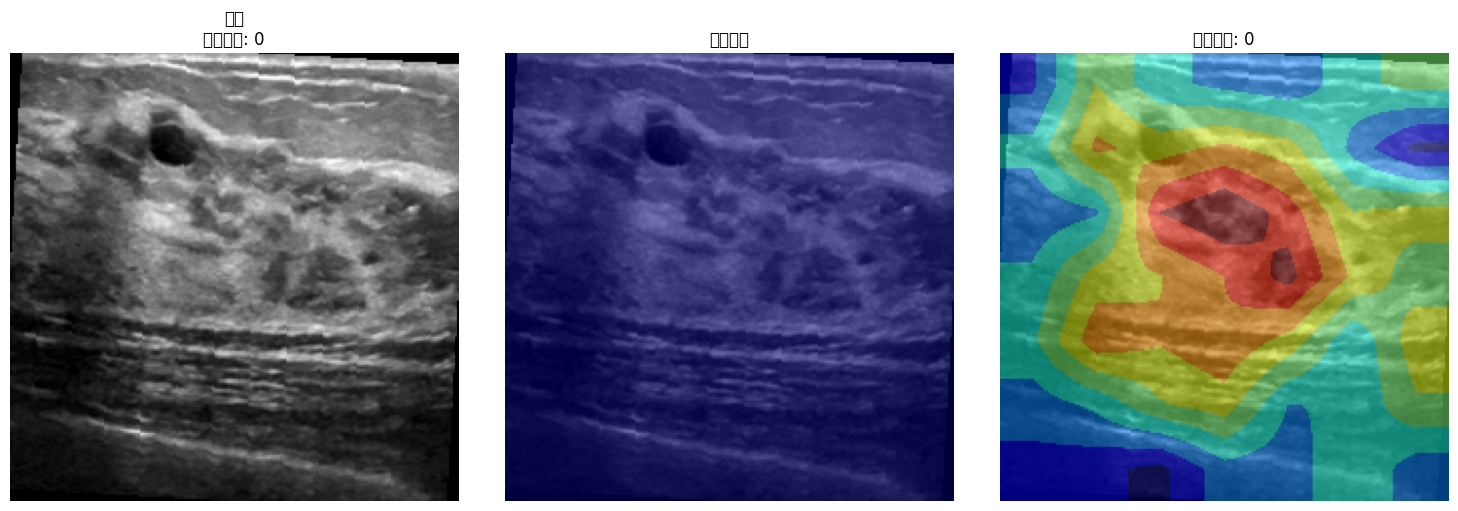

In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


# === 数据集类 ===
class BUSIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, label, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.label = label
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        try:
            image = Image.open(img_path).convert("L")
            mask = Image.open(mask_path).convert("L") if os.path.exists(mask_path) else Image.new("L", image.size)
        except Exception as e:
            raise RuntimeError(f"加载图像或掩码时出错: {e}")

        # 将灰度图像转换为 RGB
        image = Image.merge("RGB", (image, image, image))

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, self.label


# === 图像增强的变换 ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=15),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动
    transforms.ToTensor(),  # 转换为张量
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=15),  # 随机旋转
    transforms.ToTensor(),  # 转换为张量
])


# === 加载数据集 ===
def get_dataset():
    root = "./data"
    datasets = []

    for label, cls in enumerate(["benign", "malignant", "normal"]):  # 遍历类别
        img_path = os.path.join(root, cls)
        mask_path = os.path.join(root, f"{cls}_mask")
        datasets.append(BUSIDataset(img_path, mask_path, label, transform, mask_transform))

    return torch.utils.data.ConcatDataset(datasets)


# === 使用 ResNet50 定义模型 ===
class MultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=True)  # 加载预训练的 ResNet50
        self.backbone = nn.Sequential(*list(base.children())[:-2])  # 去掉最后两层
        self.cls_head = nn.Sequential(  # 分类头
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )
        self.seg_head = nn.Sequential(  # 分割头
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1)
        )

    def forward(self, x):
        feat = self.backbone(x)  # 提取特征
        pooled = F.adaptive_avg_pool2d(feat, 1).view(x.size(0), -1)  # 全局平均池化
        cls_out = self.cls_head(pooled)  # 分类输出
        seg_out = self.seg_head(feat)  # 分割输出
        seg_out = F.interpolate(seg_out, size=(224, 224), mode='bilinear', align_corners=False)  # 上采样
        return cls_out, seg_out


# === Dice 损失函数 ===
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))


# === IoU 损失函数 ===
def iou_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return 1 - ((intersection + smooth) / (union + smooth))


# === IoU 计算 ===
def calculate_iou(pred_mask, mask):
    pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
    intersection = (pred_mask * mask).sum(dim=[1, 2, 3])
    union = (pred_mask + mask).clamp(0, 1).sum(dim=[1, 2, 3])
    iou = (intersection + 1e-6) / (union - intersection + 1e-6)
    return iou


# === 训练函数 ===
def train():
    # 加载数据集
    dataset = get_dataset()
    loader = DataLoader(dataset, batch_size=16, shuffle=True)  # 增大批量大小

    # 初始化模型
    model = MultiTaskModel().cuda()

    # 使用 AdamW 优化器
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # 使用 ReduceLROnPlateau 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

    # 训练循环
    for epoch in range(50):  # 增加训练轮数
        model.train()
        cls_preds, cls_labels = [], []
        total_iou, count = 0, 0
        total_loss_cls, total_loss_seg = 0, 0

        for img, mask, label in loader:
            img, mask, label = img.cuda(), mask.cuda(), label.cuda()

            # 前向传播
            out_cls, out_seg = model(img)

            # 分类损失
            loss_cls = F.cross_entropy(out_cls, label)

            # 分割损失
            loss_seg = (F.binary_cross_entropy_with_logits(out_seg, mask) +
                        dice_loss(out_seg, mask) +
                        iou_loss(out_seg, mask))

            # 总损失
            loss = loss_cls + 0.7 * loss_seg  # 调整权重

            # 反向传播
            opt.zero_grad()
            loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()

            # 记录损失
            total_loss_cls += loss_cls.item()
            total_loss_seg += loss_seg.item()

            # 记录分类预测
            cls_preds.extend(out_cls.argmax(1).cpu().numpy())
            cls_labels.extend(label.cpu().numpy())

            # 计算 IoU
            iou = calculate_iou(out_seg, mask)
            total_iou += iou.sum().item()
            count += img.size(0)

        # 更新学习率
        scheduler.step(total_loss_cls + total_loss_seg)

        # 计算 F1 和 mIoU
        f1 = f1_score(cls_labels, cls_preds, average='macro')
        miou = total_iou / count

        # 打印训练结果
        print(f"第 {epoch + 1} 轮 | F1: {f1:.4f} | mIoU: {miou:.4f} | "
              f"分类损失: {total_loss_cls:.4f} | 分割损失: {total_loss_seg:.4f}")


# === 测试与可视化 ===
def test_and_visualize():
    from matplotlib import rcParams
    rcParams['font.sans-serif'] = ['Noto Sans CJK SC']  # 设置字体为 Noto Sans CJK
    rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    dataset = get_dataset()
    model = MultiTaskModel().cuda()
    model.eval()

    # 加载模型检查点
    checkpoint_path = "model_checkpoint.pth"
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print("模型检查点已加载。")

    sample_idx = random.randint(0, len(dataset) - 1)
    image, mask, label = dataset[sample_idx]
    image = image.unsqueeze(0).cuda()  # 添加批量维度
    label = torch.tensor([label]).cuda()

    # 推理
    with torch.no_grad():
        out_cls, out_seg = model(image)
        pred_label = out_cls.argmax(1).item()
        pred_mask = torch.sigmoid(out_seg).squeeze(0).cpu()

    # 计算分类准确率
    accuracy = (pred_label == label.item()) * 100
    print(f"预测准确率: {accuracy:.2f}%")

    # 可视化结果
    image = TF.to_pil_image(image.squeeze(0).cpu())
    mask = TF.to_pil_image(mask.squeeze(0).cpu())
    pred_mask = TF.to_pil_image(pred_mask)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title(f"图像\n真实标签: {label.item()}")
    ax[0].axis("off")

    ax[1].imshow(image)
    ax[1].imshow(mask, alpha=0.5, cmap="jet")
    ax[1].set_title("真实掩码")
    ax[1].axis("off")

    ax[2].imshow(image)
    ax[2].imshow(pred_mask, alpha=0.5, cmap="jet")
    ax[2].set_title(f"预测标签: {pred_label}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


# === 保存模型检查点 ===
def save_checkpoint(model, path="./models/model_checkpoint.pth"):
    torch.save(model.state_dict(), path)
    print(f"模型已保存到 {path}")


if __name__ == '__main__':
    checkpoint_path = "./models/model_checkpoint.pth"

    # 检查是否存在模型检查点
    if os.path.exists(checkpoint_path):
        print("检测到模型检查点，跳过训练阶段。")
    else:
        print("未检测到模型检查点，开始训练模型...")
        train()
        save_checkpoint(MultiTaskModel().cuda(), checkpoint_path)  # 保存训练后的模型

    # 测试与可视化
    test_and_visualize()